In [1]:
%matplotlib notebook

In [2]:
import exMermin as DF

In [3]:

import sys
import pylab
import numpy
import sys
from periodictable import elements
from scipy.integrate import simps as integrate
from scipy.special import hyp2f1
from scipy.optimize import newton as root
import math



from LFC import Plasma, LFC, Farid
from Units import *

In [4]:
def calculate_response(k, omega, epsilon=1e-2, verbose=False, debug=False):
    if DF_init is None:
        raise RuntimeError("Dielectric formalism is not initialized, aborting now.")
        
    # Calculate real and imaginary part of dielectric function and the response function -Im (1/eps).   
    Im_eps_rpa_k = numpy.array([DF.ImepseRPA(k.m_as(1/bohr), w.m_as(rydberg)) for w in omega*hbar ])
    Re_eps_rpa_k = numpy.array([DF.ReepseRPA(k.m_as(1/bohr), w.m_as(rydberg)) for w in omega*hbar ])
    response_rpa_k = Im_eps_rpa_k/(Re_eps_rpa_k**2 + Im_eps_rpa_k**2)
    
    if debug:
        pylab.figure()
        pylab.semilogx(w_range/plasma.plasma_frequency, Re_eps_rpa_k, ".")
        pylab.semilogx(w_range/plasma.plasma_frequency, Im_eps_rpa_k, ".")
    
    # Handle weakly damped plasmon resonance.
    # Is there a plasmon mode (Re eps = 0)
    # Is Re eps negative somewhere?
    has_negatives = Re_eps_rpa_k < 0.0

    if any(has_negatives):
        
        # Get indices of all negative Re eps
        where_negatives = numpy.where(has_negatives)
        
        # Get index of last negative Re eps.
        lo_idx = where_negatives[0][-1]
        
        # Re eps = 0 is located between lo_idx and next frequency.
        resonance_band = omega[lo_idx:lo_idx+2]*second
        if verbose:
            print("Found resonance band: ", (resonance_band/second/plasma.plasma_frequency).m, "w_pl")
        
        # Make linear interpolation on logarithmized frequencies
        xlo = omega[lo_idx]
        xhi = omega[lo_idx+1]
        ylo = Re_eps_rpa_k[lo_idx]
        yhi = Re_eps_rpa_k[lo_idx+1]
        
        resonance = xlo - ylo*(xhi-xlo)/(yhi-ylo)
            

        m2 = integrate(x=omega.m_as(1/second), y=response_rpa_k * omega.m_as(1/second))
        fsum = math.pi*(plasma.plasma_frequency.m_as(1/second))**2 / 2.
        delta = fsum - m2
        relative_deviation = abs(m2/fsum-1.)
        if verbose: print("m2     = ",m2, "\nfsum   = ", fsum, "\ndelta  = ", delta, "\n% dev. = ", relative_deviation)
        
        if abs(relative_deviation) > epsilon:
            

            Abox = 2.*delta/(resonance_band[-1]**2 - resonance_band[0]**2)

            response_rpa_k[lo_idx] += Abox
                
                
    return omega, response_rpa_k       

In [5]:
DF_init = None

In [6]:
plasma = Plasma(elements=[elements.H], electron_temperature=1.0*electronvolt/kB, electron_density=1.0e29*meter**-3, average_ionization=1.0)
DF_init = DF.InitParameters(plasma.electron_density.m_as(meter**-3), (plasma.electron_temperature*kB).m_as(electronvolt),(plasma.electron_temperature*kB).m_as(electronvolt), plasma.average_ionization)

In [7]:
fsum = 0.5*math.pi*(plasma.plasma_frequency)**2

In [8]:
k_range = DF.get_kappaeRy()/bohr * 10**numpy.linspace(-2,1.3,256)
print(k_range[0], k_range[-1])

0.00976529735594228 / bohr 19.484329808776874 / bohr


In [9]:
(hbar*plasma.plasma_frequency*100).to(electronvolt), (hbar**2*k_range[-1]**2/2/m_e*10.).to(electronvolt)

(<Quantity(1174.240868514491, 'electronvolt')>,
 <Quantity(51652.52143913383, 'electronvolt')>)

In [10]:
w_max = max(plasma.plasma_frequency*100, hbar*k_range[-1]**2/2/m_e*20.)
print("Max. frequency (hbar*omega) = ",(hbar*w_max).to(electronvolt))
log10_wmax = math.log(w_max/plasma.plasma_frequency, 10)
w_range = plasma.plasma_frequency*10**numpy.linspace(-4, log10_wmax, 2048)
assert abs(hbar*w_range[-1] - hbar*w_max) < 1e-5*electronvolt

Max. frequency (hbar*omega) =  103305.04287826768 electronvolt


In [11]:
EF = (hbar**2*plasma.kF**2/2./m_e).to(joule)
theta = (kB*plasma.electron_temperature).to(joule)/EF
eta = DF.get_etae()
D = 1./theta
vF = (hbar*plasma.fermi_wavenumber/m_e).to(meter/second)
kappa = DF.get_kappaeRy()/bohr

In [12]:
print("*** Plasma parameters report ***")
print("EF    = {0:5.4e}".format(EF.to(electronvolt)))
print("theta = {0:5.4e}".format(theta.m))
print("eta   = {0:5.4e}".format(eta))
print("kappa = {0:5.4e}".format(kappa))

*** Plasma parameters report ***
EF    = 7.8560e+00 electronvolt
theta = 1.2729e-01
eta   = 7.7484e+00
kappa = 9.7653e-01 / bohr


In [13]:
def lfc_integration_kernel(k,q,):
    return _lfc_integration_kernel_x(k/q, epsilon=1.0e-5)

In [14]:
def _lfc_integration_kernel_x(x, epsilon=1.0e-5):
    if abs(x-1.) < epsilon:
        return 5./6. - 0.5*x**2
    if abs(x) < epsilon:
        return 5./6.
    return 5./6. - 0.5*x**2 + 0.25*x**3*(1. - 1./x**2)**2 * numpy.log(abs(1.+x)/abs(1.-x))

###  Integration of RPA

In [15]:
def calculate_static_See(wavenumbers):
    sq = numpy.empty_like(wavenumbers)
    
    for iq, q in enumerate(wavenumbers):
        om, response = calculate_response(q, w_range, verbose=False)
        response = response/numpy.tanh(hbar*w_range/2./kB/plasma.electron_temperature)
        
        sq[iq] = (hbar*q**2 /math.pi/ m_e / plasma.plasma_frequency**2 * integrate(y=response,x=om)/second).m_as(one)
    
    return sq

In [16]:
#See_ks = calculate_static_See(wavenumbers=k_range)
#numpy.savetxt("See_k.txt", See_ks)

In [17]:
See_ks = numpy.loadtxt("See_k.txt")

<IPython.core.display.Javascript object>


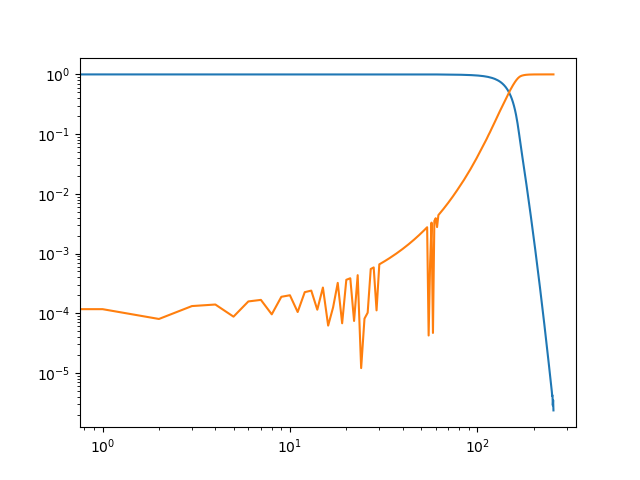

In [18]:
pylab.figure()
pylab.loglog((1.-See_ks))
pylab.loglog(See_ks)

In [19]:
def calculate_G_PV(wavenumber, Sk=None, epsilon=1e-2, ):
    """ Calculate static local field factor for given wavenumber (scalar). """
    
    
    if Sk is None:
        Sk = calculate_static_See(k_range)

    xs = (k_range/wavenumber).m_as(one)
        
    kern = numpy.array([_lfc_integration_kernel_x(x) for x in xs]) * k_range**2 * (1.-Sk)
    
    #mx = kern.max()
    #mx_idx = kern.argmax()
    #
    #for idx, ker in enumerate(kern[mx_idx:-1]):
    #    if kern[mx_idx+1] > ker or ker < mx*epsilon:
    #        break
    #    else:
    #        continue
    
    
    #pylab.figure()
    #pylab.loglog(Qs,kern)
    
    I = integrate(x=k_range, y=kern)

    return 0.25/numpy.pi**2/(plasma.electron_density*bohr**3)*I

In [20]:
Gpvs = numpy.array([calculate_G_PV(q, Sk=See_ks) for q in k_range[:-10:10]])

<IPython.core.display.Javascript object>


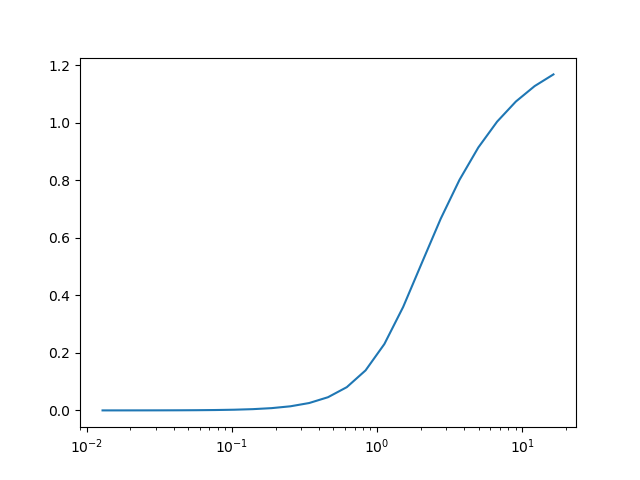

In [21]:
pylab.figure()
pylab.semilogx(k_range[:-10:10].to(1/meter)/plasma.kF,Gpvs)

## Dabrowski model for dynamic LFC

In [22]:
alpha = math.pow(4./9./math.pi, 1./3.)
C = 23./60.*alpha*plasma.rs
D = 0.763

### Use Farid for low freq. limit 

In [23]:
Gx = LFC(model=Farid, wavenumbers=k_range[:-10:10], energies=0.0*joule, plasma=plasma)

<IPython.core.display.Javascript object>


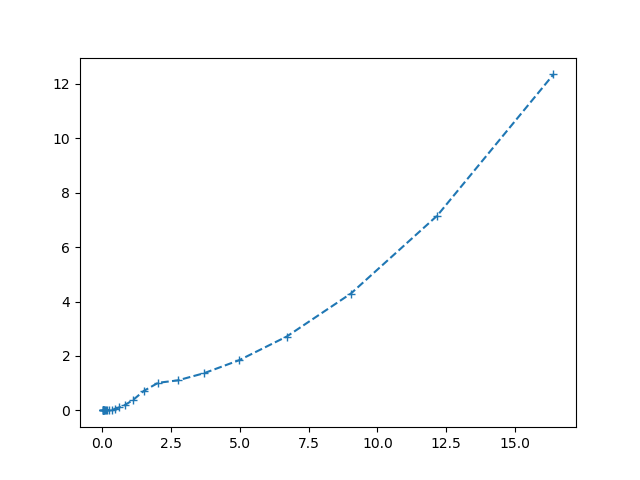

In [24]:
pylab.figure()
pylab.plot(k_range[:-10:10].to(1/meter)/plasma.kF, Gx.evaluate(), "+--")

In [25]:
def pade_coeffs(wavenumber):
    
    qaB = wavenumber.m_as(1/bohr)
    gx = Gx.evaluate([qaB]/bohr)[0]
    gpv = calculate_G_PV(qaB/bohr, See_ks)
    quot = (gx-gpv)/(C*D*qaB**2)
    
    a = C*qaB**2*quot**(5./3.)
    b = quot**(4./3.)
    
    return a.m_as(one),b.m_as(one)

In [26]:
q = k_range[200]

In [27]:
pade_coeffs(q)

(0.37322848012137855, 0.09346273642961637)

## Pade ansatz for G(q,w) 

In [28]:
def calculate_dynamic_LFC(wavenumber, w_range):
    a,b = pade_coeffs(wavenumber)
    
    qaB = wavenumber.m_as(1/bohr)
    wRy = (hbar*w_range).m_as(rydberg)
    
    Im_G = a*wRy/(1.+b*wRy**2)**1.25
    
    Re_G_w_inf = calculate_G_PV(wavenumber, See_ks) 
    Re_G   = Re_G_w_inf - a*( wRy/(1.+b*wRy**2)**1.25 + 1.5225*hyp2f1(1, 3/2, 5/4, -1./(b*wRy**2)) )
    
    return Re_G + 1j*Im_G

In [29]:
Gwq = calculate_dynamic_LFC(wavenumber=q, w_range=w_range)

<IPython.core.display.Javascript object>


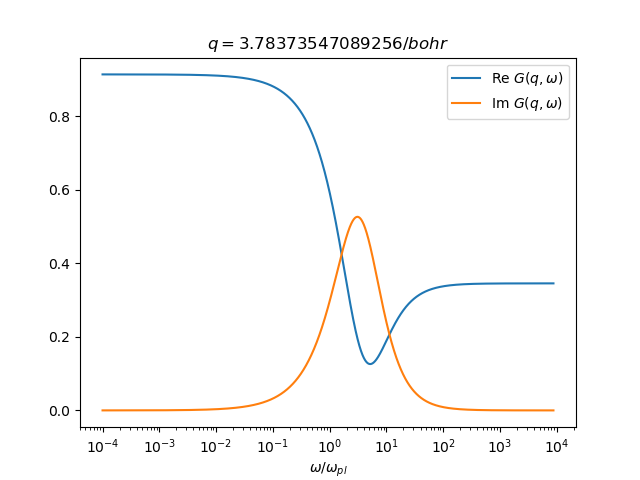

Text(0.5, 1.0, '$q = 3.78373547089256 / bohr$')

In [30]:
pylab.figure()
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.real(Gwq), label=r"Re $G(q, \omega)$")
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.imag(Gwq), label=r"Im $G(q, \omega)$")
pylab.xlabel(r"$\omega/\omega_{pl}$")
pylab.legend()
pylab.title(r"$q = {0:s}$".format(q.__str__()) )

In [41]:
G = calculate_dynamic_LFC(q, plasma.plasma_frequency).m

In [42]:
G.real , G.imag

(0.06960366383891943, 0.013910521428370327)

In [43]:
def calculate_See0(k, w, G):
    Re_G = G.real.m
    Im_G = G.imag.m
    
    hws = (hbar*w).m_as(rydberg)
    
    See_kw_s = numpy.empty_like(w)
    for i, hw in enumerate(hws):
        print(i, hw, Re_G[i], Im_G[i])
        See_kw_s[i] = DF.See0(k.m_as(1/bohr), hw, Re_G[i], Im_G[i])
    
    return See_kw_s

In [44]:
q = 0.5*DF.get_kappaeRy()/bohr
hw = DF.get_wpleRy()

In [45]:
Gwq = calculate_dynamic_LFC(q, w_range)

In [46]:
Re_G = Gwq.real.m
Im_G = Gwq.imag.m

In [48]:
def dispersion_relation(hwRy, qaB):
    G = calculate_dynamic_LFC(qaB/bohr, hwRy*rydberg/hbar).m    
    return DF.dispersionGM(qaB, hwRy, G.real, G.imag)

In [52]:
DF.get_kappaeRy()

0.976529735594228

In [53]:
DF.get_kFRy()

0.7598737888761451

In [54]:
dispersion_relation(DF.get_wpleRy(), 2.0*DF.get_kappaeRy())

-96.81783762684707

In [40]:
def calculate_dispersion(q):
    wplRy = DF.get_wpleRy()
    kaB = q.m_as(1/bohr)
    return root(dispersion_relation, wplRy, args=(kaB,))

In [ ]:
calculate_dispersion(1*plasma.debye_kappa)/DF.get_wpleRy()

In [61]:
dispersionLFC = [calculate_dispersion(x*DF.get_kappaeRy()/bohr) for x in numpy.linspace(0.1, 1.3, 20)]*rydberg

In [ ]:
pylab.figure()
qs = [x*DF.get_kappaeRy() for x in numpy.linspace(0.1, 1.3, 20)]/bohr
pylab.plot(qs, (dispersionLFC*rydberg).to(electronvolt))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


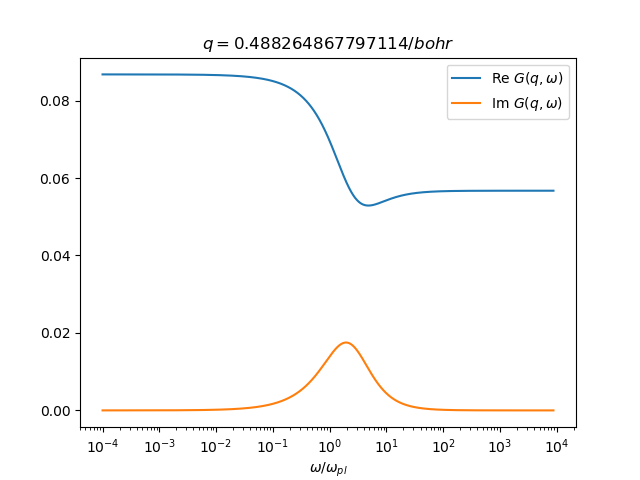

Text(0.5, 1.0, '$q = 0.488264867797114 / bohr$')

In [37]:
pylab.figure()
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.real(Gwq), label=r"Re $G(q, \omega)$")
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.imag(Gwq), label=r"Im $G(q, \omega)$")
pylab.xlabel(r"$\omega/\omega_{pl}$")
pylab.legend()
pylab.title(r"$q = {0:s}$".format(q.__str__()) )

In [36]:
Gwq = calculate_dynamic_LFC(wavenumber=q, w_range=w_range)

In [ ]:
See_kw_s = calculate_See0(0.5*DF.get_kappaeRy()/bohr, w_range, Gwq)

# Appendix

<IPython.core.display.Javascript object>


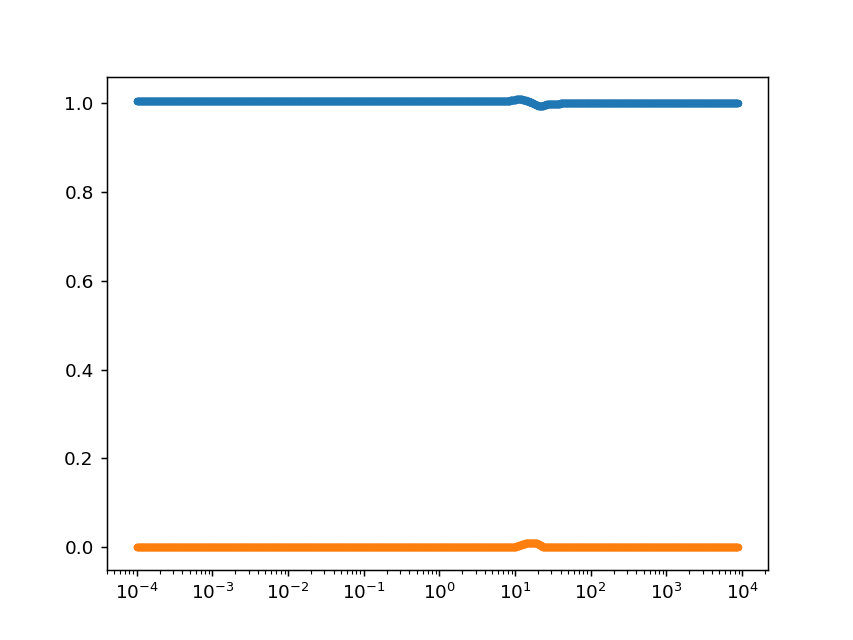

<IPython.core.display.Javascript object>


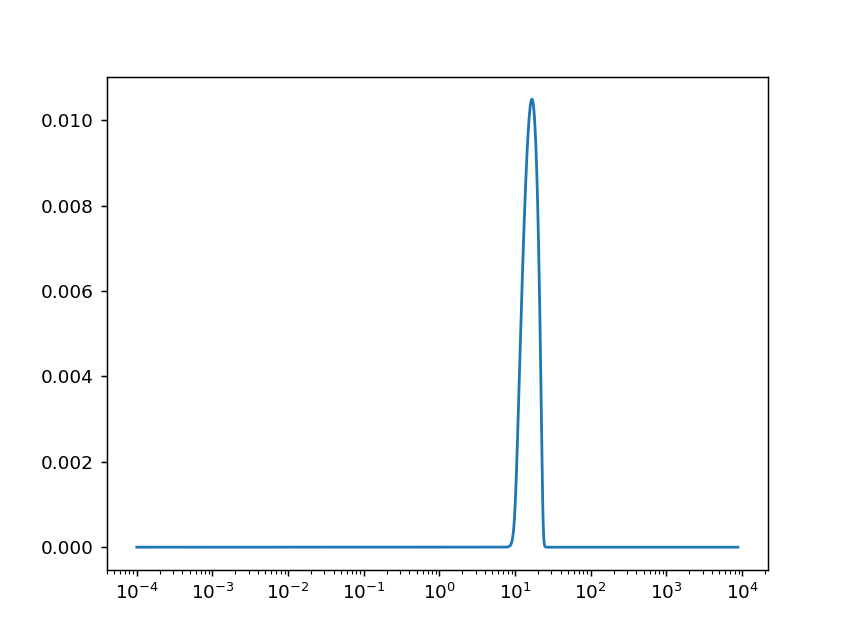

In [36]:
k = 20./bohr
w, response = calculate_response(q, omega=w_range, verbose=True, debug=True)

pylab.figure()
pylab.semilogx(w/plasma.plasma_frequency, response)

<IPython.core.display.Javascript object>


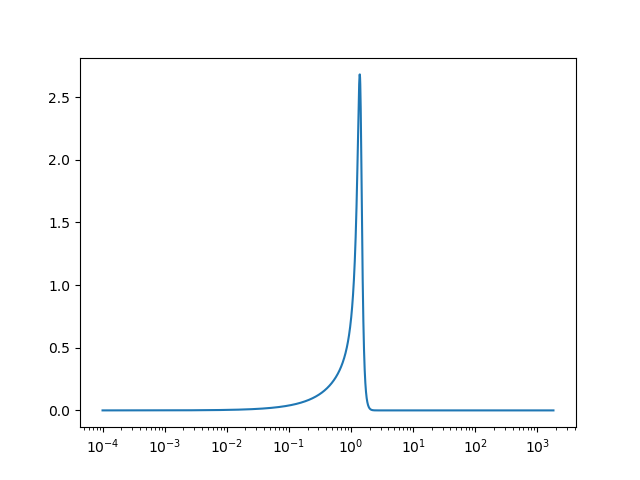

In [360]:
k = plasma.debye_kappa*0.5
w, response = calculate_response(k=k, omega=w_range, verbose=False)

pylab.figure()
pylab.semilogx(w/plasma.plasma_frequency, response)

<IPython.core.display.Javascript object>


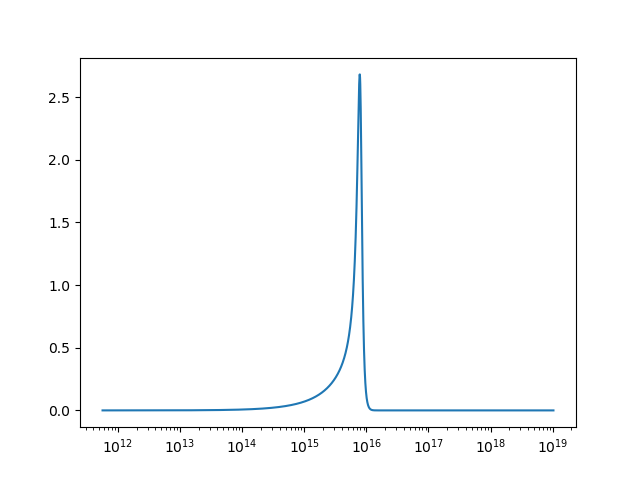

In [308]:
x,y = calculate_response(k, w_range)
pylab.figure()
pylab.semilogx(x,y)

In [ ]:
for k in k_range:
    

In [264]:
fsum = 0.5*math.pi*(plasma.plasma_frequency.m_as(1/second))**2; fsum

4.999227933850756e+31

In [244]:
def calculate_response_large_k(k, omega, verbose=False, debug=False):
    """ Table II in Arista,Brandt 1984 col. 2, row 4."""
    
    u = (omega/k/vF).to(one)
    z = 0.5*(k/plasma.fermi_wavenumber).to(one)
    
    return 0.125/plasma.kF/bohr/z**3 * theta * numpy.log(1. + numpy.exp(eta - D*(u-z)**2))

In [292]:
def calculate_response_large_k_classical(k, omega, verbose=False, debug=False):
    """ Table II in Arista,Brandt 1984 col. 4, row 4."""
    
    u = (omega/k/vF).to(one)
    z = 0.5*(k/plasma.fermi_wavenumber).to(one)
    if verbose:
        print("u = [", u[0], "..", u[-1])
        print("z = ", z)
    
    x = 2.*z
    g = DF.ge(x.m)
    
    Re_eps = 1. + 2./(plasma.kF*bohr).to(one)/numpy.pi*pow(plasma.kF/k, 3) * g
    Im_eps = 0.125/plasma.kF/bohr/z**3 * theta * numpy.exp(eta - D*(u-z)**2)
    
    return Im_eps/(Re_eps**2 + Im_eps**2)

In [296]:
k = 5.*plasma.debye_kappa
response_large_k = calculate_response_large_k(k, w_range[1000:])
response_large_k_cl = calculate_response_large_k_classical(k, w_range[1000:], verbose=True)
w,response_k = calculate_response(k, w_range[1000:])

u = [ 0.01953352098915351 dimensionless .. 111.50069645125286 dimensionless
z =  7.405944513552496 dimensionless


<IPython.core.display.Javascript object>


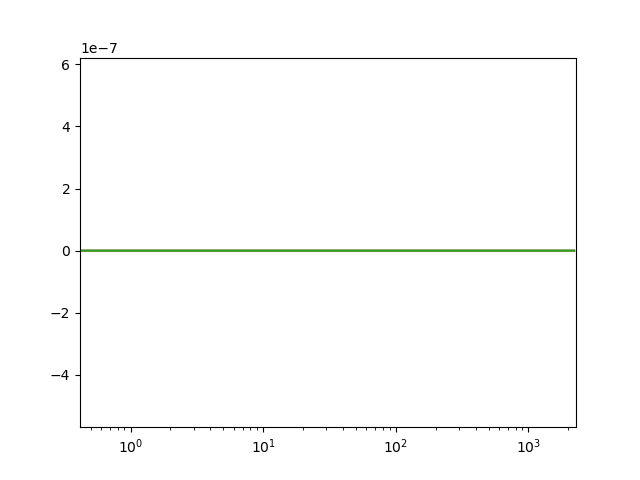

In [294]:
pylab.figure()
pylab.plot(w/plasma.plasma_frequency, response_large_k)
pylab.plot(w/plasma.plasma_frequency, response_large_k_cl)
pylab.plot(w/plasma.plasma_frequency, response_k)


<IPython.core.display.Javascript object>


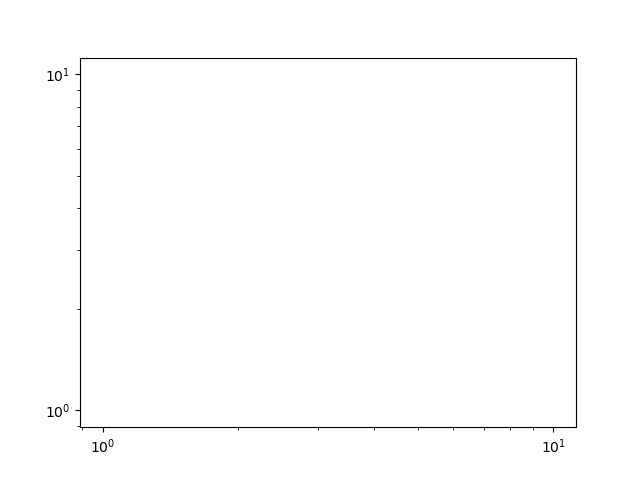

ValueError: x and y must have same first dimension, but have shapes (2048,) and (1048,)

In [295]:
pylab.figure()
pylab.loglog(w_range/plasma.plasma_frequency, response_large_k)
pylab.loglog(w_range/plasma.plasma_frequency, response_large_k_cl)
pylab.loglog(w_range/plasma.plasma_frequency, response_k)


In [17]:
# kern = numpy.array([[_lfc_integration_kernel_x(x) for x in k_range/q] for q in k_range[:-10]])

In [19]:
# kern.shape

(246, 256)

<IPython.core.display.Javascript object>


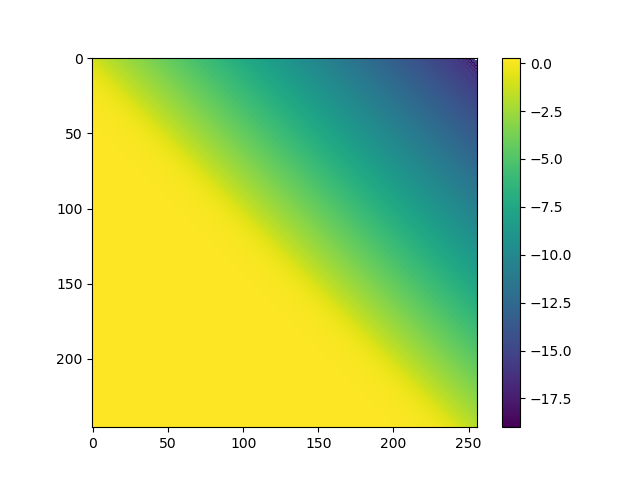

/home/grotec/Codes/anaconda3/envs/simex/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [20]:
# pylab.figure()
# pylab.imshow(numpy.log(kern))
# pylab.colorbar()

<IPython.core.display.Javascript object>


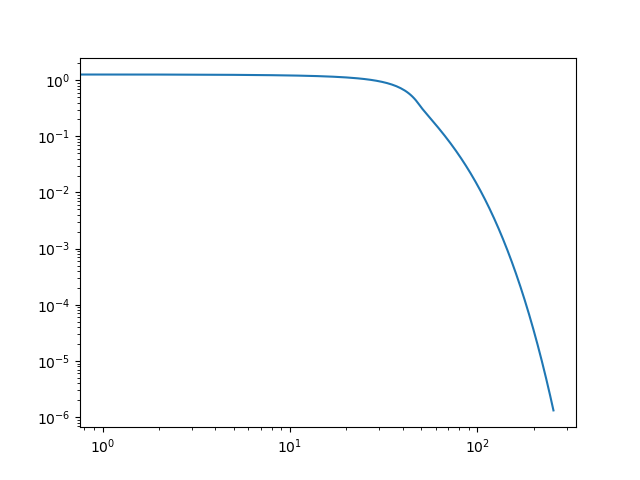

In [55]:
pylab.figure()
pylab.loglog(kern[50,:])

<IPython.core.display.Javascript object>


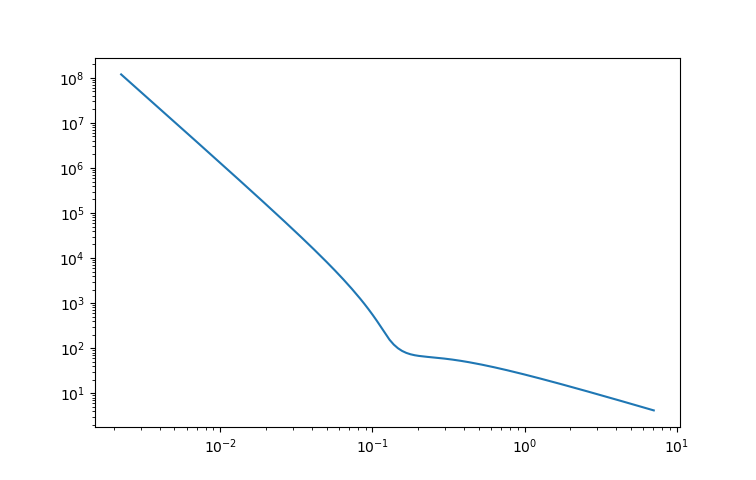

In [57]:
pylab.figure()
pylab.loglog(k_range*bohr, kern/k_range**3)